In [1]:
import graph_tool as gt
from graph_tool.draw import graph_draw
import graph_tool.collection
import graph_tool.generation as gen
import axelrod as axl
import pandas as pd
import toolz as tz
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice, sample
from copy import deepcopy
from collections import Counter
from itertools import product
from time import time
from math import floor
import ternary

%matplotlib inline


In [2]:
# project params
outputPath = './sf.png'


In [3]:
# network params
N = _N = 1000
_m = 2
_c = 0 
_gamma = 1

# game params
_R=1
_P=0
_T=1.5 # T€[0,2] 
_S=-.5 # S€[-1,1]

# evo params
_episode_n = 100
_te = 1
_ta = 0.5
_W = _te/_ta
# _tm = 0.3 # for mediator evolution
_beta = 0.05

In [4]:
'''Utils'''
def transposeList(l) = list(map(list, zip(*l)))

In [5]:
'''Init''' 
C = 'C'
D = 'D'
def initStrats(N) = [choice([C,D]) for i in range(N)]
GOOD_MED = 'GOOD_MED'
BAD_MED = 'BAD_MED'
NO_MED = 'NO_MED'
def initMedStrats(N) = [choice([GOOD_MED,BAD_MED,NO_MED]) for i in range(N)]
def initPayoffs(N) = [0 for i in range(N)]

'''Graph'''
def sample_k(max):
    accept = False
    while not accept:
        k = np.random.randint(1,max+1)
        accept = np.random.random() < 1.0/k
    return k
def initGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gen.price_network(N=N, m=m, c=c, gamma=gamma, directed=False)
def initRandomGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gt.generation.random_graph(N, x->sample_k(40), directed=False)
def getNeighborIds(graph, id) = graph.vertex(id).out_neighbors() |> map$(int) |> list
def sampleNeighbor(graph, id) = choice(getNeighborIds(graph, id))
def sampleNeighborUnique(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list |> choice
def isLonely(graph, x) = len(graph.get_all_edges(x)) == 1 #checks if node has only 1 edge
def rewireEdge(graph, x, y, z):
    _graph = graph
    _graph.remove_edge(_graph.edge(x,y))
#     print(f'adding {x},{z}')
    _graph.add_edge(x, z)
    return _graph
# neighbors of id1 eligible for rewiring id2 to 
def eligibleNewFriends(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list
def sampleStrat(strats, strat) = enumerate(strats) |> filter$(x-> x[1] == strat) |> list |> eligible -> None if not eligible else (choice(eligible) |> .[0])
def medSampleStrat(strats, medStrats, med, strat):
    users = enumerate(medStrats) |> filter$(x-> x[1] == med) |> map$(.[0]) |> list
    sampledUser = users |> filter$(i-> strats[i] == strat) |> list |> eligible -> None if not eligible else choice(eligible)
    return sampledUser
'''Games'''
def makeDilemma(R=_R, P=_P, T=_T, S=_S) = {C:{C:[R,R], D:[S,T]}, D:{C:[T,S], D:[P,P]}} # T€[0,2] S€[-1,1]
dilemma = makeDilemma()
# playDilemma :: [strat] -> id -> id -> float
def playDilemma(dilemma, strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
# cumulativePayoffs :: graph -> [strat] # 1 round of all connections playing one another
def cumulativePayoffs(N, dilemma, graph, strats):
    payoffs = initPayoffs(N)
    idPlayDilemma = playDilemma$(dilemma, strats) 
    for [x,y] in graph.iter_edges():
        px,py = idPlayDilemma(x,y)
        payoffs[x] += px
        payoffs[y] += py
    return payoffs


In [6]:
'''Mediators'''

# noMediator :: graph -> id -> id -> id
def noMediator(graph, y, x):
    eligible = eligibleNewFriends(graph, y, x)
    return None if not eligible else choice(eligible)
def _noMediator(graph, strats, medStrats, y, x):
    return noMediator(graph, y, x)
def useNoMed(graph, strats, medStrats, y, x) = noMediator(graph, y, x)


# goodMediator :: graph -> id -> id -> id
def goodMediator(graph, strats, medStrats, y, x):
    z = medSampleStrat(strats, medStrats, GOOD_MED, C)
    return None if not z else z
def useGoodMed(graph, strats, medStrats, y, x) = goodMediator(graph, strats, y, x)

# badMediator :: graph -> id -> id -> id
def badMediator(graph, strats, medStrats, y, x):
    z = medSampleStrat(strats, medStrats, BAD_MED, D)
    return None if not z else z
def useBadMed(graph, strats, medStrats, y, x) = badMediator(graph, strats, y, x)

medDict = {NO_MED:_noMediator, GOOD_MED:goodMediator, BAD_MED:badMediator}
def useMed(med, graph, strats, medStrats, y, x) = med(graph, strats, medStrats, y, x)

In [7]:
'''Structural Update'''
def attemptRewire(graph, strats, medStrats, x, y):
#     if isLonely(graph, x) or isLonely(graph, y): 
    if isLonely(graph, y): 
#         print(f'{x},{y} is lonely')
        return graph #enforcing graph connectedness
    _graph = graph
    z = useMed(medDict[medStrats[x]], _graph, strats, medStrats, y, x)
    if not z:
        return graph
    new_graph = rewireEdge(_graph, x, y, z)
    return new_graph

def updateTies(graph, strats, medStrats, payoffs, x):
    y = sampleNeighbor(graph, x)
#     print(f'updating {x}({strats[x]}),{y}({strats[y]})')
    args = [[x,y], [y,x]]
    p = fermi(_beta, payoffs[x] - payoffs[y])        
    if (strats[x] == C and strats[y] == D):
        return attemptRewire(graph, strats, medStrats, x, y)
    elif (strats[x] == D and strats[y] == D):
        return  np.random.choice([0,1], p=[p, 1-p]) |> args[] |*> attemptRewire$(graph, strats, medStrats)
    return graph
    


In [8]:
'''Strategy Evolution'''
def fermi(beta, fitness_diff) = np.clip(1. / (1. + np.exp(beta * fitness_diff, dtype=np.float64)), 0., 1.)
def calcK(graph, x, y) = 
    def deg(z) = graph.vertex(z).out_degree()
    max(deg(x), deg(y))
def calcD(T=_T, S=_S) = max(T, 1) - min(S, 0)
def transProb(calcK, P, x, y) = (P[y] - P[x]) / (calcK(x, y) * calcD())
# updateStrat :: graph -> [strat] -> [float] -> id -> strat
def updateStrat(graph, strats, payoffs, x) = 
    _calcK = calcK$(graph)
    y = sampleNeighbor(graph, x)
#   p = transProb(_calcK, payoffs, x, y)
    p = fermi(_beta, payoffs[x] - payoffs[y])     
    strats[x] if payoffs[x] > payoffs[y] else np.random.choice([strats[y], strats[x]], p=[p, 1-p])
# updateStrat :: graph -> [strat] -> [float] -> [strat]
def updateStrats(N, graph, strats, payoffs):
    _strats = deepcopy(strats)
    for x in range(N):
        _strats[x] = updateStrat(graph, _strats, payoffs, x)
    return _strats
# chooses between structural and strat updates
def evoUpdate(N, graph, W, strats, medStrats, payoffs): 
    _strats = deepcopy(strats)
    _medStrats = deepcopy(medStrats)
    _graph = graph
    p = 1/(1+W)
    for x in range(N):
        doStratUpdate = np.random.choice([True, False], p=[p, 1-p])
        if doStratUpdate:
            _medStrats[x] = updateStrat(graph, _medStrats, payoffs, x) # fixed strats, vary rewiring, vary meds
#             _strats[x] = updateStrat(graph, _strats, payoffs, x)
        else:
            _graph = updateTies(graph, _strats, _medStrats, payoffs, x)
    return _graph, _strats, _medStrats

In [9]:
'''run'''
# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def runEvolution( N, episode_n, dilemma, graph, W, strats, medStrats, payoffs):
    stratEpisodes = [strats]
    medStratEpisodes = [medStrats]
    totalPayoffs = initPayoffs(N)
    _strats = []
    _medStrats =[]
    _graph = deepcopy(graph)
    for i in range(episode_n):
        payoffs = cumulativePayoffs(N, dilemma, _graph, strats)
        new_graph, _strats, _medStrats = evoUpdate(N, _graph, W, strats, medStrats, payoffs)
        stratEpisodes.append(deepcopy(_strats))
        medStratEpisodes.append(deepcopy(_medStrats))
        totalPayoffs = np.add(totalPayoffs, payoffs)
        strats = _strats
        medStrats = _medStrats
        _graph = new_graph
    return _graph, totalPayoffs, stratEpisodes, medStratEpisodes

def runExperiment(W, N=_N, episode_n=_episode_n, dilemmaParams={'R':_R, 'P':_P, 'T':_T, 'S':_S}):
    strats = initStrats(N)
    medStrats = initMedStrats(N)
    totalPayoffs = initPayoffs(N)
    graph = initGraph(N=N)
#     dilemma = makeDilemma(R=_R, P=_P, T=_T, S=_S)
    dilemma = makeDilemma(**dilemmaParams)
    _graph, totalPayoffs, stratEpisodes, medStratEpisodes = runEvolution(N, episode_n, dilemma, graph, W, strats, medStrats, totalPayoffs)
    return _graph, totalPayoffs, stratEpisodes, medStratEpisodes

def runTSExperiment(M, N=_N, episode_n=_episode_n, W=_W, initGraph=initGraph):
    start = time()
    strats = initStrats(N)
    totalPayoffs = initPayoffs(N)
    graph = initGraph(N=N)
    t_ = np.linspace(0,2,M)
    s_ = np.linspace(-1,1,M)
    _ts = product(t_, s_)|>list
    listDilemmaParams = [{'R':_R, 'P':_P, 'T':ts[0], 'S':ts[1]} for ts in _ts]
    results = [runEvolution(N, episode_n, makeDilemma(**p), graph, W, strats, medStrats, totalPayoffs) for p in listDilemmaParams]
    end = time()
    print(f'running t,s experiment N={N}, epN={episode_n} W={W}, took {floor(end-start)}s')
    return _ts, results

In [15]:
# Plots
def drawGraph(graph) = graph_draw(graph, bg_color="white") 
def plotHist(_list, bins) = pd.Series(_list).hist(bins = bins)
def plotStratEvo(episodes) = pd.DataFrame([dict(Counter(ep)) for ep in episodes]).plot.line()
def coopLandscape(ts, res, title='', axis=None):
    cCounts = [Counter(stratEpisodes[-1])['C'] for graph, totalPayoffs, stratEpisodes, medStratEpisodes in res]
    M = len(cCounts)
    df = pd.DataFrame(zip(cCounts, *transposeList(ts)), columns=['count', 't', 's'])
    df = df.pivot('s', 't', 'count').iloc[::-1]
    if not axis:
        ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2).set_title(title)
        plt.show()
    else:
        ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2, ax=axis).set_title(title)
def matrixCoopLandscape(meds, ws, allRes):
    fig, axes = plt.subplots(len(meds),len(ws), figsize=(25,15))
    i=0
    for medName, medRes in allRes.items():
        j = 0
        for w, wRes in medRes.items():
            expName = f'{medName} w={w}'
            ts, res = wRes
            coopLandscape(ts, res, expName, axes[i][j])
            j += 1
        i += 1
    fig.tight_layout()
    plt.show()
    
def simplexPath(episodes, title):
    ## Sample trajectory plot
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary()
    tax.gridlines(multiple=0.2, color="black")
    tax.set_title(title, fontsize=20)
    points = []
    # Plot the data
    tax.plot(episodes, linewidth=2.0, label="Curve")
    tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")
    tax.legend()
    tax.show()

def simplexPaths(runs, title=''):#
    
    fontsize=10
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary()
    tax.gridlines(multiple=0.2, color="black")
    tax.set_title(title, fontsize=20, y=1.08)
    points = []
    tax.right_corner_label(NO_MED, fontsize=fontsize)
    tax.top_corner_label(GOOD_MED, fontsize=fontsize)
    tax.left_corner_label(BAD_MED, fontsize=fontsize)

    # Plot the data
    for run in runs:
        tax.plot(run, linewidth=2.0, label="Curve")
    tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")
    tax.legend()
    tax.show()
    

def makePropVector3(ep):
    N = len(ep)
    count = Counter(ep)
    vec = np.array([count[NO_MED], count[GOOD_MED], count[BAD_MED]])
    return vec/N

def medPropSimplex(runs, title=''):
    vecRuns = map(map$(makePropVector3), runs)
    simplexPaths(vecRuns,title)
    return

In [13]:
# graph, totalPayoffs, stratEpisodes, medStratEpisodes = runExperiment(0.5, N=1000, episode_n=100)
runs = [runExperiment(0.5, N=500, episode_n=1000)[-1] for i in range(3)]

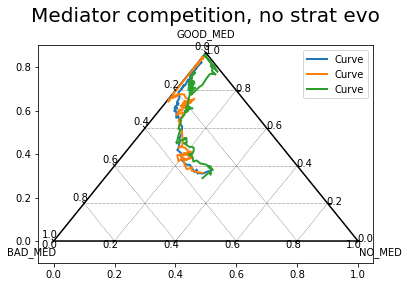

In [16]:
medPropSimplex(runs, 'Mediator competition, no strat evo')

In [29]:
def randVec():
    v = np.random.rand(3)
    v_hat = v / v.sum()
    return v_hat

In [12]:
def runManyExperiments(meds, ws, tsDim=9, N=100, episode_n=2, initGraph=initGraph):
    allRes = {med.__name__: {w: runTSExperiment(tsDim, med, N=N, episode_n=episode_n, W=w, initGraph=initGraph) for w in ws} for med in meds}
    matrixCoopLandscape(meds, ws, allRes)

running t,s experiment N=100, epN=2 med=useGoodMed W=1, took 1s
running t,s experiment N=100, epN=2 med=useGoodMed W=2, took 1s
running t,s experiment N=100, epN=2 med=useNoMed W=1, took 2s
running t,s experiment N=100, epN=2 med=useNoMed W=2, took 2s
running t,s experiment N=100, epN=2 med=useBadMed W=1, took 2s
running t,s experiment N=100, epN=2 med=useBadMed W=2, took 2s


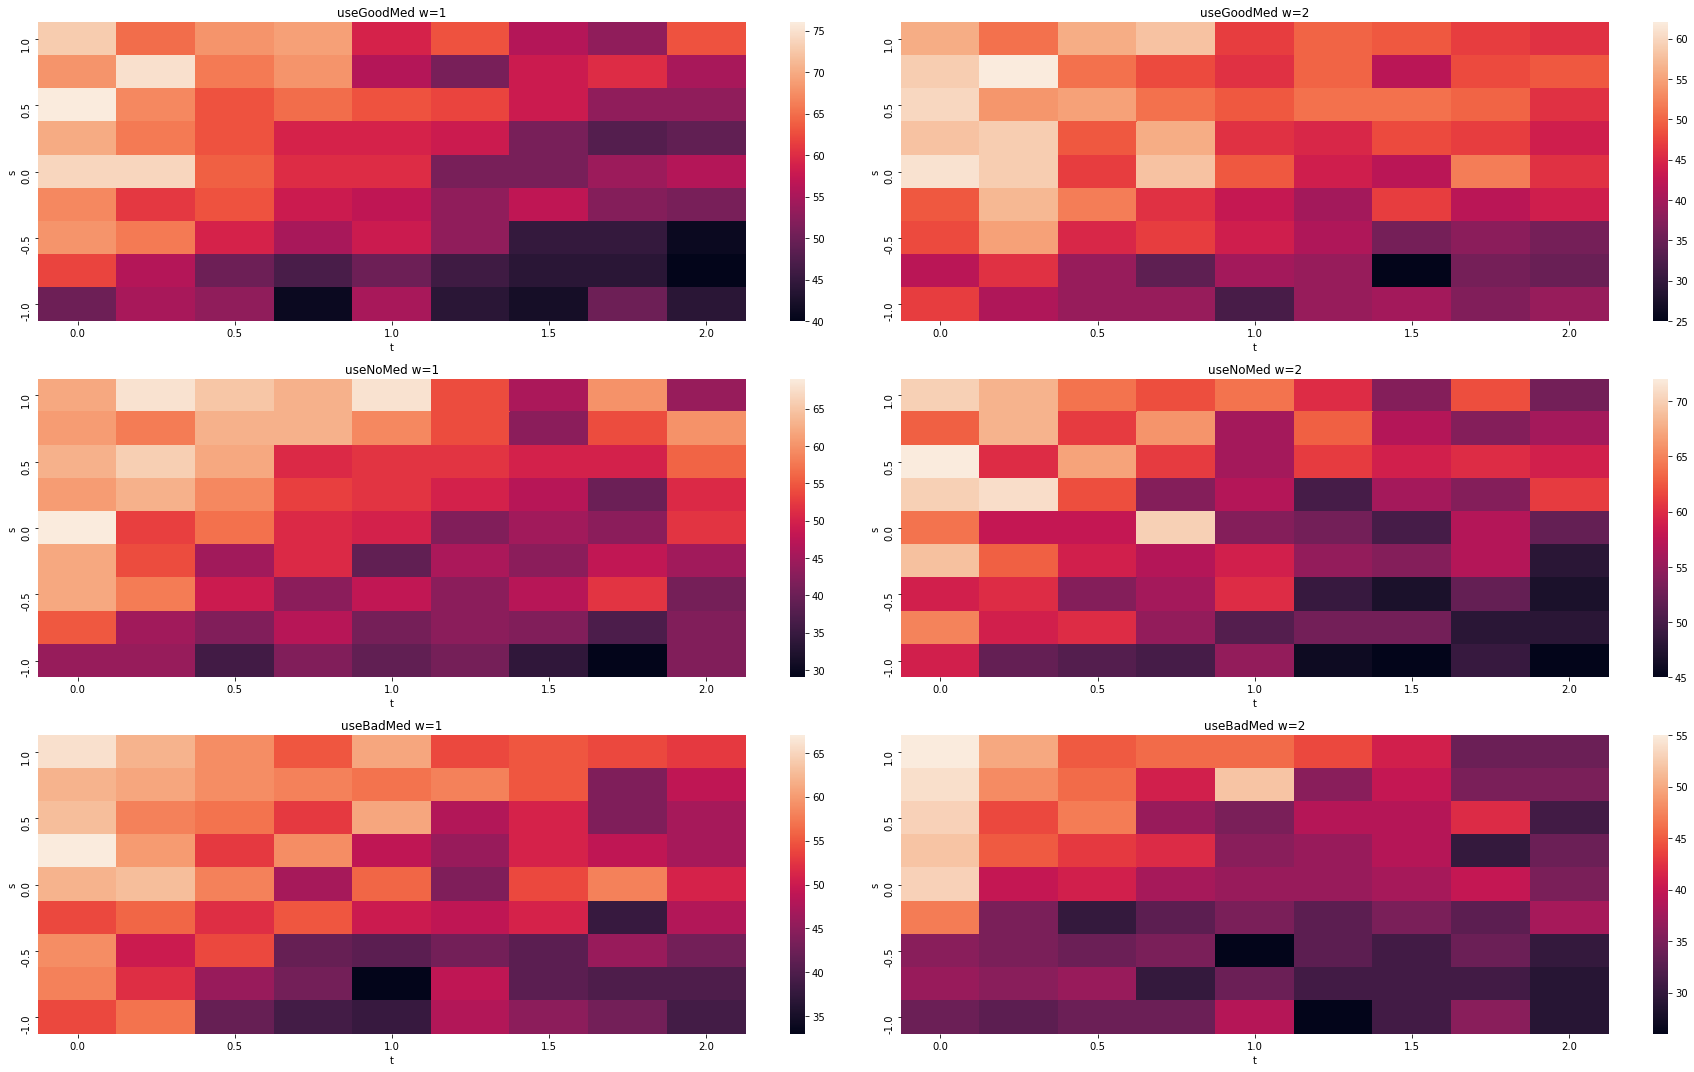

In [19]:
meds = [useGoodMed, useNoMed, useBadMed]
# ws = [0.5, 1, 2, 3, 4]
ws = [1,2]
runManyExperiments(meds, ws, tsDim=9, N=100, episode_n=2)


In [ ]:
meds = [useGoodMed, useNoMed, useBadMed]
ws = [0.5, 1, 2, 3, 4]
runManyExperiments(meds, ws, tsDim=9, N=100, episode_n=20, initGraph=initRandomGraph)


running t,s experiment N=100, epN=20 med=useGoodMed W=0.5, took 38s
running t,s experiment N=100, epN=20 med=useGoodMed W=1, took 47s
running t,s experiment N=100, epN=20 med=useGoodMed W=2, took 56s
running t,s experiment N=100, epN=20 med=useGoodMed W=3, took 47s
running t,s experiment N=100, epN=20 med=useGoodMed W=4, took 43s
running t,s experiment N=100, epN=20 med=useNoMed W=0.5, took 48s
